In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr



### based on Copy8, change num_samples = 100

In [2]:
#import creep data
creep_df = pd.read_csv('../PI_Data/PI_SS316_dataset.csv')
creep_df

,Material,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,...,B,N,Nb+Ta,Elongation,Reduction of Area,Stress,Temperature,Stacking Fault Energy,PI_creep_feature,creep_rupture_life
0,0,0.060,0.59,1.69,0.024,0.017,13.32,16.73,2.38,0.07,...,0.0010,0.0300,0.020,55,61,235,650,66.7612,1.4382,29.2
1,1,0.050,0.52,1.51,0.021,0.010,13.21,16.42,2.34,0.14,...,0.0005,0.0340,0.010,68,78,157,700,66.6025,1.4285,34.5
2,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.0008,0.0318,0.010,72,77,235,650,65.2279,1.4716,38.8
3,18,0.012,0.56,0.81,0.024,0.004,10.67,16.39,2.11,0.27,...,0.0010,0.0810,0.001,106,80,177,700,58.7002,1.5759,39.0
4,8,0.060,0.52,1.58,0.025,0.007,13.60,16.60,2.31,0.26,...,0.0007,0.0224,0.010,75,83,157,700,66.6248,1.5669,40.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.0008,0.0318,0.010,41,55,118,600,65.2279,5.1788,142185.9
613,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.0011,0.0250,0.010,26,39,108,600,66.6471,5.2890,152758.0
614,2,0.050,0.71,1.52,0.022,0.013,13.50,17.50,2.28,0.17,...,0.0013,0.0350,0.020,28,37,108,600,64.2349,5.2471,173814.3
615,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.0011,0.0250,0.010,25,23,41,700,66.6471,5.3538,178190.4


In [3]:
Log_Creep_Life = np.log10(creep_df['creep_rupture_life'])
creep_df['Log_Creep_Life'] = Log_Creep_Life
creep_df = creep_df.drop(columns = ['creep_rupture_life'])

In [4]:
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Material               617 non-null    int64  
 1   C                      617 non-null    float64
 2   Si                     617 non-null    float64
 3   Mn                     617 non-null    float64
 4   P                      617 non-null    float64
 5   S                      617 non-null    float64
 6   Ni                     617 non-null    float64
 7   Cr                     617 non-null    float64
 8   Mo                     617 non-null    float64
 9   Cu                     617 non-null    float64
 10  Ti                     617 non-null    float64
 11  Al                     617 non-null    float64
 12  B                      617 non-null    float64
 13  N                      617 non-null    float64
 14  Nb+Ta                  617 non-null    float64
 15  Elonga

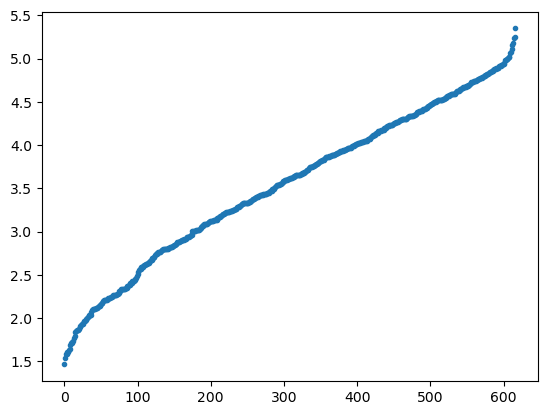

In [5]:
plt.plot(creep_df['Log_Creep_Life'], '.')

In [6]:
features = creep_df.iloc[:, 0:21]
targets = creep_df.iloc[:, 21]
features

,Material,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,...,Al,B,N,Nb+Ta,Elongation,Reduction of Area,Stress,Temperature,Stacking Fault Energy,PI_creep_feature
0,0,0.060,0.59,1.69,0.024,0.017,13.32,16.73,2.38,0.07,...,0.015,0.0010,0.0300,0.020,55,61,235,650,66.7612,1.4382
1,1,0.050,0.52,1.51,0.021,0.010,13.21,16.42,2.34,0.14,...,0.018,0.0005,0.0340,0.010,68,78,157,700,66.6025,1.4285
2,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.020,0.0008,0.0318,0.010,72,77,235,650,65.2279,1.4716
3,18,0.012,0.56,0.81,0.024,0.004,10.67,16.39,2.11,0.27,...,0.011,0.0010,0.0810,0.001,106,80,177,700,58.7002,1.5759
4,8,0.060,0.52,1.58,0.025,0.007,13.60,16.60,2.31,0.26,...,0.021,0.0007,0.0224,0.010,75,83,157,700,66.6248,1.5669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,7,0.060,0.52,1.60,0.025,0.007,13.30,16.70,2.25,0.24,...,0.020,0.0008,0.0318,0.010,41,55,118,600,65.2279,5.1788
613,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.017,0.0011,0.0250,0.010,26,39,108,600,66.6471,5.2890
614,2,0.050,0.71,1.52,0.022,0.013,13.50,17.50,2.28,0.17,...,0.027,0.0013,0.0350,0.020,28,37,108,600,64.2349,5.2471
615,6,0.070,0.61,1.65,0.025,0.007,13.60,16.60,2.33,0.26,...,0.017,0.0011,0.0250,0.010,25,23,41,700,66.6471,5.3538


In [7]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

class BNN(PyroModule):
    def __init__(self, in_dim=21, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

# Coverage
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future

Run # 1 Fold # 1


Sample: 100%|██████████| 200/200 [07:23,  2.22s/it, step size=1.30e-03, acc. prob=0.925]


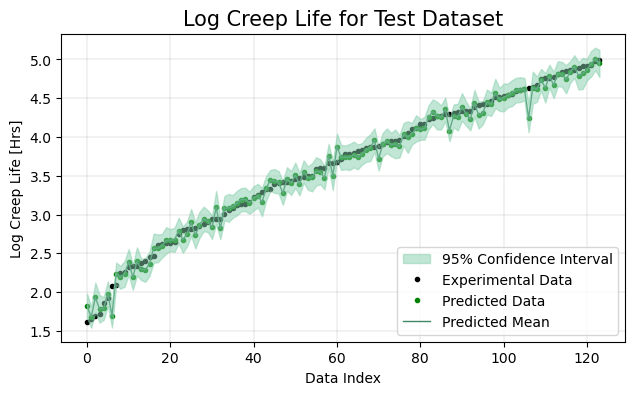

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

Pearson CC: 0.9949913523305718
R2 score: 0.9894602920424227
RMSE: 0.09148561189263717
MAE: 0.0654459498319764
Coverage: 93.54838709677422
Interval Width: 0.3136312961578369
Composite Metric: 1.4987272316191884
********************
Run # 1 Fold # 2


Sample: 100%|██████████| 200/200 [07:09,  2.15s/it, step size=1.10e-03, acc. prob=0.912]


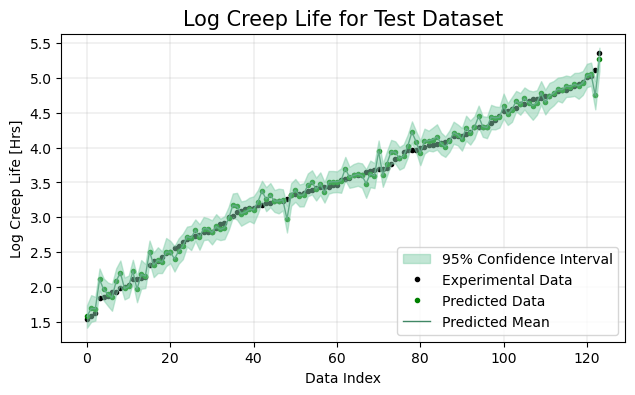

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

Pearson CC: 0.9951719453095047
R2 score: 0.9899592438004113
RMSE: 0.09294215452864846
MAE: 0.06524110876745215
Coverage: 91.93548387096777
Interval Width: 0.3317239284515381
Composite Metric: 1.443154858583608
********************
Run # 1 Fold # 3


Sample: 100%|██████████| 200/200 [07:19,  2.20s/it, step size=9.57e-04, acc. prob=0.956]


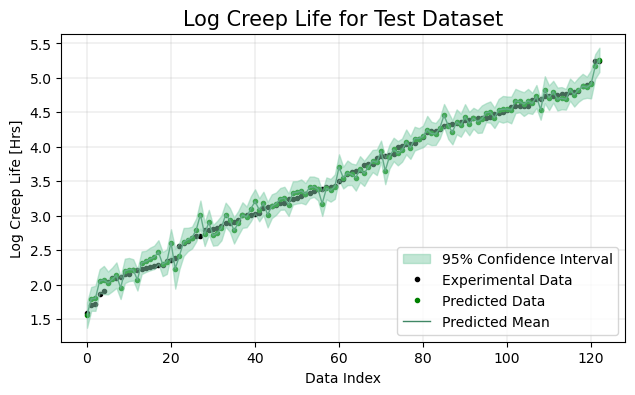

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

Pearson CC: 0.9957184084005518
R2 score: 0.9912237487083083
RMSE: 0.0879965409435663
MAE: 0.06720722148692003
Coverage: 91.86991869918695
Interval Width: 0.34110283851623535
Composite Metric: 1.42194118767507
********************
Run # 1 Fold # 4


Sample: 100%|██████████| 200/200 [07:07,  2.14s/it, step size=9.27e-04, acc. prob=0.943]


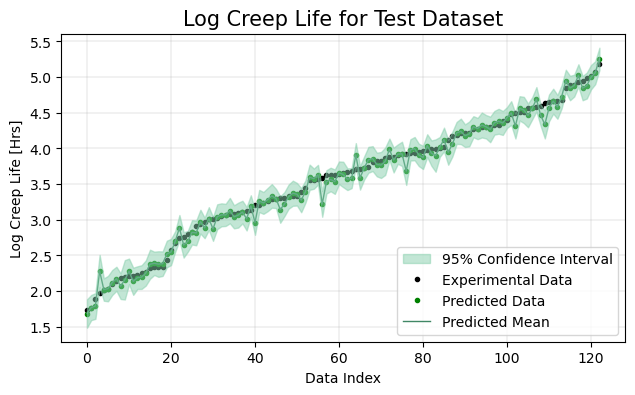

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

Pearson CC: 0.994579400820685
R2 score: 0.9887412326734636
RMSE: 0.09150176525507192
MAE: 0.06585606058560367
Coverage: 94.30894308943085
Interval Width: 0.3353719711303711
Composite Metric: 1.4527580208962527
********************
Run # 1 Fold # 5


Sample: 100%|██████████| 200/200 [07:09,  2.15s/it, step size=6.58e-04, acc. prob=0.979]


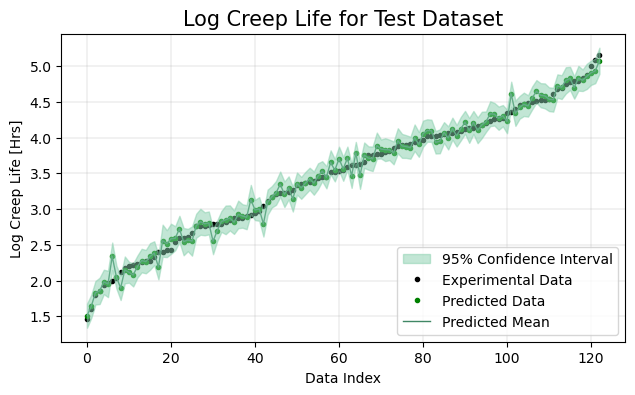

Pearson CC: 0.9946215829209394
R2 score: 0.9891255334816782
RMSE: 0.09168503561851611
MAE: 0.06861591538889317
Coverage: 93.49593495934955
Interval Width: 0.33132028579711914
Composite Metric: 1.4557763887791446
********************


c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

In [8]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)


test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            # define DNN
            model = BNN(hid_dim=10, n_hid_layers=3, prior_scale=1)
            nuts_kernel = NUTS(model, jit_compile=False)
            mcmc = MCMC(nuts_kernel, num_samples=100)
            mcmc.run(torch.Tensor(x_train), torch.Tensor(y_train.to_numpy()))

            # evaluate the model on test data
            predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
            preds = predictive(torch.Tensor(x_test))

            y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
            y_std = preds['obs'].T.detach().numpy().std(axis=1)

            ## Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')

            fig.delaxes(ax[1])
            plt.show()

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))


            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
 

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std
            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')


            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            print(20*'*')

In [10]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.994991,0.989460,0.091486,0.065446
1,0.995172,0.989959,0.092942,0.065241
2,0.995718,0.991224,0.087997,0.067207
3,0.994579,0.988741,0.091502,0.065856
4,0.994622,0.989126,0.091685,0.068616


In [11]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)


PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)


# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std
                   },index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.995017,0.000416,0.989702,0.00086,0.091122,0.001654,0.066473,0.001272


In [12]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Median Interval Width,Composite Metric
0,93.548387,0.313631,1.498727
1,91.935484,0.331724,1.443155
2,91.869919,0.341103,1.421941
3,94.308943,0.335372,1.452758
4,93.495935,0.331320,1.455776


In [13]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,93.031734,0.965946,0.33063,0.009196,1.454472,0.025098
